# Forças Intermoleculares Fracas 

Nesta atividade, você irá examinar as algumas proprieades das interações fracas entre moléculas. Como as subunidades moleculares não estão conectados por nenhuma ligação covalente ou iônica, nos referimos usualmente as interações intermoleculares como in *interações não-covalentes*. Suponha que queremos calcular a energia de interação entre a molécula A e a molécula B para uma certa geometria do complexo A-B (óbviamente, esta energia de interação depende de quão distante as moléculas estão e como elas estão orientadas). A forma mais simples de realizar esta tarefa seria através da subtração (esta abordadem é chamada de *abordagem supermolecular*, é a mais empregada por químicos teóricos):

$E_{\rm int}=E_{\rm A-B}-E_{\rm A}-E_{\rm B}$

em que $E_{\rm X}$ é a energia total do sistema X, computado usando nossa teoria favorita de estrutura eletrônica e um certo conjunto de funções de base. Um valor negativo de  $E_{\rm int}$ indica que a molécula A e B tem energia mais baixa quando estão juntas naquela configuração do que quando elas estão infinitamente separadas, então eles formam um complexo ligado que pode ser estável pelo menos em temperaturas muito baixas. Um valor positivo de $E_{\rm int}$ indica que o complexo A-B não é ligado - é energeticamente mais favorável se A e B se separarem (repulsões). 

Vamos considerar primeiramente um exemplo extremamente simples de dois átomos interagentes de Hélio e calcular $E_{\rm int}$ em algumas distâncias interatômicas distintas $R$. Você usará o pacote gratuito Psi4 para calcular as energias total que você precisa para realizar a subtração. Quando fizermos estes calculos para uma série de valores de $R$, você será capaz de construir as famosas *curva de energia potencial* - o gráfico de $E_{\rm int}(R)$ em função de $R$.

BELEZA, mas como você escolherá o método de estrutura eletrônica para calcular $E_{\rm A-B}$, $E_{\rm A}$, and $E_{\rm B}$? Vamos começar pela escolha mais simples e tentar o método Hartree-Fock (HF). Caso o HF não seja acurado o suficiente, tentaremos um método mais sofisticado como o *coupled-cluster* com excitações simples, duplas e triplas perturbativas - CCSD(T). Se você nunca ouviu falar sobre CCSD(T) antes, vamos apenas dizer que **(1)** geralmente é muito preciso (muitos se referem a este método como *gold standard* da teoria de estrutura eletrônica) e **(2)** é computacionalmente muito pesado para moléculas maiores - de certa forma até inviável. Com relação ao conjunto de funções de base, vamos escolher a base de Dunning aug-cc-pVTZ que deve estar OK para HF e CCSD(T).


## Dímero de Hélio

Aqui está um script python que emprega o Psi4 para computar a curva de energia potencial para dois átomos de Hélio empregando uma abordagem supramolecular. Primeiramente vamos importar algumas bibliotecas importantes

In [1]:
import sys; sys.path.append("/usr/lib/x86_64-linux-gnu/") 
import time
import numpy as np
import scipy
from scipy.optimize import *
np.set_printoptions(precision=5, linewidth=200, threshold=2000, suppress=True)
import psi4
import matplotlib.pyplot as plt

# Set Psi4 & NumPy Memory Options
psi4.set_memory('1 GB')
psi4.core.set_output_file('output.dat', False)

numpy_memory = 2

psi4.set_options({'basis': 'aug-cc-pVTZ',
              'e_convergence': 1e-10,
              'd_convergence': 1e-10,
              'INTS_TOLERANCE': 1e-15})



  Memory set to 953.674 MiB by Python driver.


Agora iremos coletar alguns pontos de dados para construir o gráfico da função $E_{\rm int}(R)$. Desta forma, vamos construir uma lista de distâncias $R$ entre os átomos de Hélio para o qual iremos realizar os cálculos (escolhi 11 distâncias baseados em testes preliminares). Para cada distânica, precisamos lembrar de três valores ($E_{\rm A-B}$, $E_{\rm A}$, and $E_{\rm B}$). Para este propósito, iremos preparar dois $11\times 3$ arrays do NumPy (_array é uma estrutura multidimensional que nos permite armazenar dados na memória do nosso computador_) para guardar os resultados dos cálculos HF e CCSD(T). 

In [2]:
distances = [4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]

Estamos quase prontos para obter alguns números! =D Porém, surge uma questão: como vamos dizer para o Psi4 se queremos $E_{\rm A-B}$, $E_{\rm A}$, ou $E_{\rm B}$? 
Precisamos definir três geometrias diferentes. Para a energia $E_{\rm A-B}$ são necessários dois átomos de Hélio separados $R$ unidades um do outro - podemos posicionar um átomo em $(0,0,0)$ e o outro em $(0,0,R)$. As outras duas geometrias envolvem na verdade apenas um átomo de Hélio, com um núcleo e dois elétrons, e um *átomo ghost* no lugar do outro átomo. Um átomo ghost não possui núcleo tampouco elétrons, mas ele carrega as funções de base de um átomo verdadeiro - precisamos calcular todas as energias com o mesmo conjunto de funções de base, com funções centradas em $(0,0,0)$ e $(0,0,R)$, para evitar o chamado *erro de superposição de base*. No Psi4, a sintaxe `Gh(X)` denota um átomo ghost onde as funções de base onde o átomo tipo X está localizado. 

Empregando átomos fantasmas, podemos agora facilmente definir as geometrias para o cálculo das energias $E_{\rm A}$ e $E_{\rm B}$. Esta etapa pode demorar alguns minutos dependendo da arquiterura de seu computador. No meu computador pessoal consegui realizar os cálculos em todas as distâcnais em menos de 5 minutos.

In [3]:
hf_r = {}
hf_ra = {}
hf_rb = {}

cssdt_r = {}
cssdt_ra = {}
cssdt_rb = {}

for i in distances:
  dimer = psi4.geometry("""
  He 0.0 0.0 0.0
  --
  He 0.0 0.0 """+str(i)+"""
  units bohr
  symmetry c1
  """)

  psi4.energy('ccsd(t)')   #HF sera calculado simulataneamente
  
  hf_r[i] = (psi4.variable('HF TOTAL ENERGY'))
  cssdt_r[i] = (psi4.variable('CCSD(T) TOTAL ENERGY'))

  psi4.core.clean()

  monomerA = psi4.geometry("""
  He 0.0 0.0 0.0
  --
  Gh(He) 0.0 0.0 """+str(i)+"""
  units bohr
  symmetry c1
  """)

  psi4.energy('ccsd(t)')   #HF sera calculado simultaneamente

  hf_ra[i] = (psi4.variable('HF TOTAL ENERGY'))
  cssdt_ra[i] = (psi4.variable('CCSD(T) TOTAL ENERGY'))

  psi4.core.clean()

  monomerB = psi4.geometry("""
  Gh(He) 0.0 0.0 0.0
  --
  He 0.0 0.0 """+str(i)+"""
  units bohr
  symmetry c1
  """)

  psi4.energy('ccsd(t)')   #HF sera calculado simultaneamente

  hf_rb[i] = (psi4.variable('HF TOTAL ENERGY'))
  cssdt_rb[i] = (psi4.variable('CCSD(T) TOTAL ENERGY'))

  psi4.core.clean()

Completamos os cálculos das energias $E_{\rm A-B}$, $E_{\rm A}$, ou $E_{\rm B}$ para todas as 11 distâncias $R$. Vamos agora realizar as subtrações e conversões de unidades atômicas para kcal/mol para formar NumPy arrays com os valores de $E_{\rm int}(R)$ para cada método e construir um gráfico resultante apresentando as curvas de energia potencial usando a biblioteca do matplotlib. Na linha ```plt.savefig('pec.png',dpi=300)``` você pode salvar o gráfico com o nome desejado com extensão png.

HF PEC [0.8550536642556786, 0.2620064720605875, 0.07873838663739023, 0.02328568276196963, 0.00680609745202644, 0.0019758670622896093, 0.0005713648338973405, 0.0001645056016549802, 4.7022875970077925e-05, 1.3273988401907744e-05, 3.6618360670974684e-06, 9.711838158619201e-07, 2.455873911149098e-07]
CCSD(T) PEC [0.6349060401204519, 0.14168039626793907, 0.011414243930097556, -0.01537510139813745, -0.01604569854107938, -0.011960696566016607, -0.008208725073621005, -0.005544660917076355, -0.0037746405469916687, -0.0026118275453447196, -0.0018410386788901016, -0.0013216623501823338, -0.0009651747855022874]


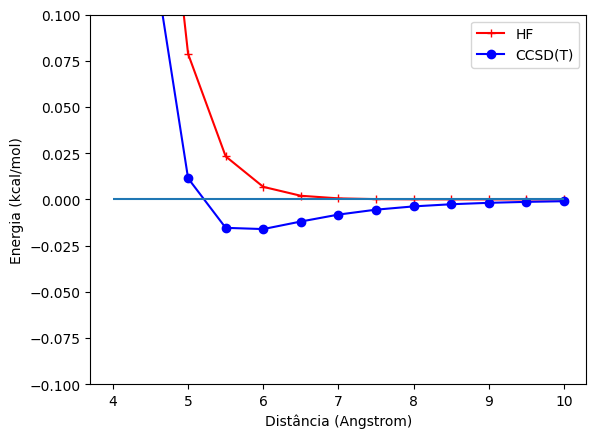

<Figure size 640x480 with 0 Axes>

In [5]:
einthf = []
eintccsdt = []
for i,j in hf_r.items():
    einthf.append((hf_r[i] - (hf_ra[i] + hf_rb[i])) * 627.509)
    eintccsdt.append((cssdt_r[i] - (cssdt_ra[i] + cssdt_rb[i])) * 627.509)


print ('HF PEC', einthf)
print ('CCSD(T) PEC', eintccsdt)

plt.plot(distances,einthf,'r+',linestyle='-',label='HF')
plt.plot(distances,eintccsdt,'bo',linestyle='-',label='CCSD(T)')
plt.hlines(0.0,4.0,10.0)
plt.xlabel('Distância (Angstrom)')
plt.ylabel('Energia (kcal/mol)')
plt.ylim(-0.10,0.10)
plt.legend(loc='upper right')
plt.show()
plt.savefig('pec_He_dimer.png',dpi=300)

Você pode personalisar suas curvas olhado a documentação do matplotlib (https://matplotlib.org/2.1.1/api/_as_gen/matplotlib.pyplot.plot.html) escolhendo outros marcadores, tipos de traço e cores distintas.

*Questionamentos* 
1. Qual curva faz mais sentido físico?
2. Por que o Hélio só forma fase líquida em temperaturas muito baixas $T_{ebu}=4.2K$?
3. Quando aumentamos o tamanho das moléculas interagentes, o método CCSD(T) rapidamente se torna computacionalmente muito caro e os cálculos podem levar semanas em vez de minutos. Se torna especialmente caro o cálculo do termo $E_{\rm A-B}$ porque A-B tem mais elétrons que A ou B separadamente. Um "colega" sugere usar CCSD(T) somente para os termos mais fáceis $E_{\rm A}$ e $E_{\rm B}$ e então subtraí-los do termo $E_{\rm A-B}$ calculados com um método mais "barato" como HF. Por que esta é uma ideia ruim?



Uma boa característica da abordagem supermolecular é que ela é muito fácil de usar - você precisa apenas rodar três cálculos padrão de energia, e códigos modernos de química quântica como o Psi4 oferecem um vasto cardápio de métodos para se escolher. Entretanto, a precisão da subtração subtraction depende de cancelamento de erros e precisamos ter cuidado para garantir que o cancelamento de erros entre $E_{\rm A-B}$ e $E_{\rm A}+E_{\rm B}$. Outro ponto fraco da abordagem supermolecular é que ela não é particularmente rica em informações físicas. Tudo que obtemos é um único número $E_{\rm int}$ que pouco nos diz sobre a física que sublinha a interação. Desta forma, seria interessante buscar uma abordagem alternativa em que $E_{\rm int}$ seja computada diretamente, sem subtração que forneça termos físicamente significativos. O método chamado Symmetry-adapted perturbation theory (SAPT) é uma abordagem alternativa desta categoria.